In [1]:
import sys, os
sys.path.insert(0, '../..')
from project_utils import *

//anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
# https://brainiak.org/tutorials/10-isc/
from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc

BOLD shape: (97, 115, 97, 63)
Mask shape: (97, 115, 97)


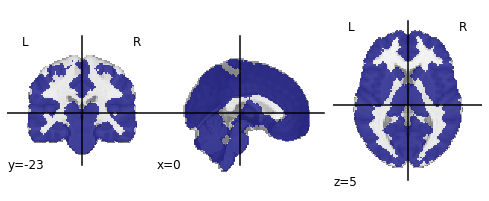

In [3]:
# get images
beta_imgs = np.array(glob.glob(f'{lsa_dir}/beta_images/*beta*'))
sub_df    = get_image_ids(beta_imgs)

# brain mask
brain_nii  = nil.masking.compute_multi_brain_mask(beta_imgs, mask_type='gm', threshold=0.25, connected=False)
plotting.plot_roi(brain_nii)
brain_mask = brain_nii.get_fdata() == 1
coords     = np.where(brain_mask) # nonzero voxel coordinates
print(f'BOLD shape: {nib.load(beta_imgs[0]).shape}')
print(f'Mask shape: {brain_nii.shape}')

In [6]:
# load in bold images
images = {}
masked_images = {}
bold = {}
for dx in ['CD','HC']:
    
    print(f'Loading images for {dx}')
    
    # mask images
    dx_mask           = (sub_df['dx']==dx) & (sub_df['incl']==1)
    beta_imgs_        = list(beta_imgs[dx_mask][0:2])
    images[dx]        = io.load_images(beta_imgs_)
    masked_images[dx] = image.mask_images(images[dx], brain_mask)
    
    # concatenate masked images 
    bold[dx] = image.MaskedMultiSubjectData.from_masked_images(masked_images[dx], len(beta_imgs_))
    bold[dx][np.isnan(bold[dx])] = 0 # convert nans into zeros

Loading images for CD
Loading images for HC


In [ ]:
# run ISC, loop over conditions 
isc_maps = {}
for dx in ['CD','HC']:
    
    print(f'Running ISC for {dx}')
    isc_maps[dx] = isc(bold[dx], pairwise=True) # ...
    print('Shape of %s group:' % task_name, np.shape(isc_maps[dx]))

In [ ]:
subj_id = 0
save_data = True
isc_vol = np.zeros(brain_nii.shape) # make the ISC output a volume
isc_vol[coords] = isc_maps[dx][subj_id, :] # map the ISC data into brain space
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header) # make a nii image of the isc map 

# save the ISC data as a volume
if save_data: 
    isc_map_path = os.path.join(dir_out, 'ISC_%s_sub%.2d.nii.gz' % (task_name, subj_id))
    nib.save(isc_nifti, isc_map_path)